## Wine Classification

Jason Dean  
July 6th, 2017  
jtdean@gmail.com   
https://github.com/jtdean123

Here we build a simple decision tree to predict whether a wine is white or red based on the following attributes:

● Fixed acidity  
● Free sulphur dioxide  
● Volatile acidity  
● Total sulphur dioxide  
● Citric acid  
● Residual sugar  
● pH  

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import itertools
import time
from sklearn.tree import export_graphviz
import subprocess
from IPython.display import Image

### Exploratory Data Analysis

In [2]:
# read the data
wine = pd.read_csv('wine.csv')
wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,free_sulfur_dioxide,total_sulfur_dioxide,ph,class
0,7.4,0.70,0.00,1.9,11.0,34.0,3.51,1
1,7.8,0.88,0.00,2.6,25.0,67.0,3.20,1
2,7.8,0.76,0.04,2.3,15.0,54.0,3.26,1
3,11.2,0.28,0.56,1.9,17.0,60.0,3.16,1
4,7.4,0.70,0.00,1.9,11.0,34.0,3.51,1


In [3]:
# quick sanity check to make sure we have numerical data and not str
string_alert = False
for i in range(0, wine.shape[1]):
    for j in range(0, wine.shape[0]):
        if type(wine.iloc[j,i]) is str:
            print 'type str at :  ', j, i
            sting_alert = True
            
if string_alert == False:
    print 'congrats, no strings'

congrats, no strings


In [4]:
type(wine.iloc[3,2])

numpy.float64

We have 7 features avaialable to us, and to start we will use all of them.  Next we determine the number of observations in the data set.

In [5]:
print 'Number of observations:  ', wine.shape[0]

Number of observations:   6497


There are 6497 wine observations and each one is either white or red.  Red wine is indiciated by a class value of '1' and white wine by '0'.

In [6]:
print 'Number of red wine observations:  ', wine[wine['class'] == 1].shape[0]
print 'Number of white wine observations:  ', wine[wine['class'] == 0].shape[0]

Number of red wine observations:   1599
Number of white wine observations:   4898


It appears this is a moderately unbalanced data set - there are exactly 3 times as many white wine observations are there are red.  Next, like the good data scientists we are, we check for missing data.

In [7]:
wine.isnull().values.any()

False

No missing data - it appears that wine was not being consumed during data entry.  We will also check for duplicated data entries.

In [8]:
wine.duplicated().values.any()

True

Some of the observations, or rows, in the data frame are duplicated.  Since there is not a unique wine identifier this may not be a problem - it is possible for two different wines to have identical values for each of the features.  However, if a red and white wine have identical values for all of the features then this would introduce problems during model buidling.  Now that have checked for missing data we can start exploring the data.  We start with summary statistics of each feature. 

In [9]:
# evaluate mean grouped by class
wine.groupby(['class']).mean()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,free_sulfur_dioxide,total_sulfur_dioxide,ph
class,,,,,,,
0,6.854788,0.278241,0.334192,6.391415,35.308085,138.360657,3.188267
1,8.319637,0.527821,0.270976,2.538806,15.874922,46.467792,3.311113


As shown above, red wine has lower fixed and volatile acidity, higher citric acid, residual sugar, free and total SD, and, consistent with these measurments, lower mean pH.  Taken together, this data indicates that red wine is, on average, more acidic and contains more sugar than white wine.  The mean as a summary statistic can be misleading if a feature is skewed, so we next evaluate the median.  

In [10]:
wine.groupby(['class']).median()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,free_sulfur_dioxide,total_sulfur_dioxide,ph
class,,,,,,,
0,6.8,0.26,0.32,5.2,34.0,134.0,3.18
1,7.9,0.52,0.26,2.2,14.0,38.0,3.31


The median values for these features are similar to the mean, indicating that there is not significant skew (maybe...) in the data and that the conclusions we stated above with regards to acidity seem valid. Since is seems that pH and sugar content are key differentiators between red and white wine we will visualize them with histograms.  We start with fixed acidity, a measure of nonvolatile acids.

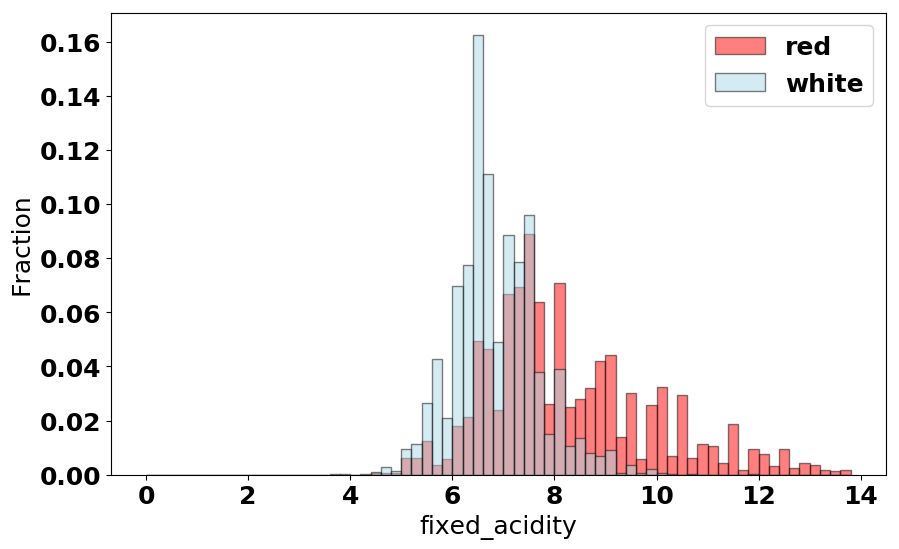

In [14]:
# pH
red_pH = list(wine[wine['class'] == 1]['fixed_acidity'])
white_pH = list(wine[wine['class'] == 0]['fixed_acidity'])

font = {'weight' : 'bold',
        'size'   : 18}
    
plt.rc('font', **font)

weights_r = np.ones_like(red_pH)/len(red_pH)
weights_w = np.ones_like(white_pH)/len(white_pH)

bins = np.arange(0,14,0.2)
plt.figure(figsize=(10, 6))
plt.hist(red_pH, bins, alpha=0.5, label='red', color='red', edgecolor = "black", weights=weights_r)
plt.hist(white_pH, bins, alpha=0.5, label='white', color='lightblue', edgecolor = "black", weights=weights_w)
plt.legend(loc='upper right')
plt.xlabel('fixed_acidity')
plt.ylabel('Fraction')

plt.show()
plt.rcdefaults()

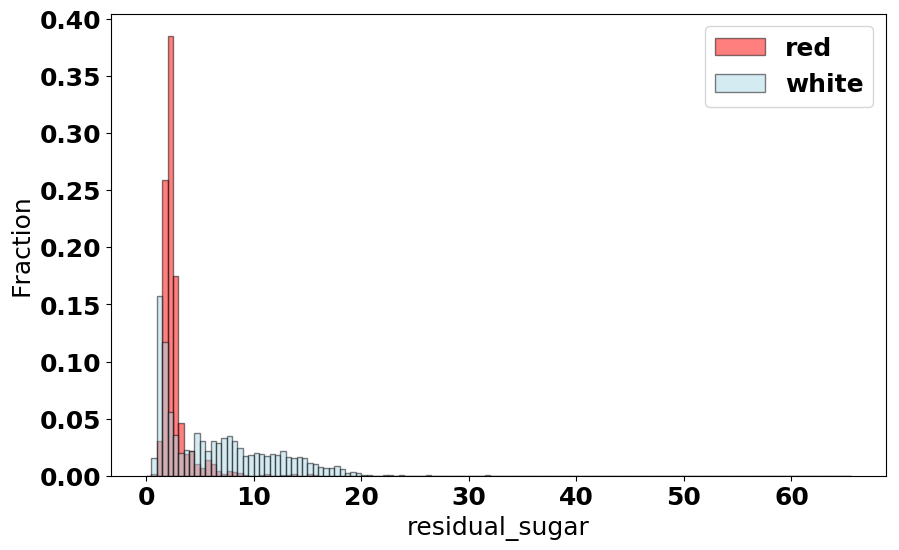

In [13]:
# sugar
red_sugar = list(wine[wine['class'] == 1]['residual_sugar'])
white_sugar = list(wine[wine['class'] == 0]['residual_sugar'])

font = {'weight' : 'bold',
        'size'   : 18}
    
plt.rc('font', **font)

weights_r = np.ones_like(red_pH)/len(red_pH)
weights_w = np.ones_like(white_pH)/len(white_pH)

bins = np.arange(0,wine['residual_sugar'].max(),0.5)
plt.figure(figsize=(10, 6))
plt.hist(red_sugar, bins, alpha=0.5, label='red', color='red', edgecolor = "black", weights=weights_r)
plt.hist(white_sugar, bins, alpha=0.5, label='white', color='lightblue', edgecolor = "black", weights=weights_w)
plt.legend(loc='upper right')
plt.xlabel('residual_sugar')
plt.ylabel('Fraction')

plt.show()
plt.rcdefaults()

Interestingly, although we found that red wine has a highher mean and median residual sugar content than white wine we see that the residual sugar distribution for white wine shows a right skew, indicating that some types of white wine contain much more sugar than others.  Riesling!  Finally, we examine the relationship between residual sugar and pH.

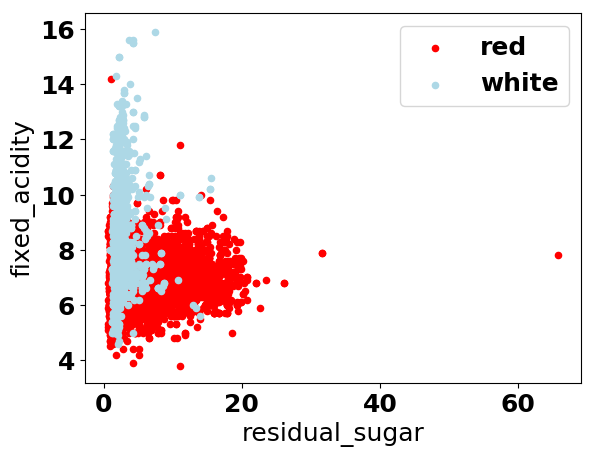

In [15]:
# sugar vs. pH
font = {'weight' : 'bold',
        'size'   : 18}
    
plt.rc('font', **font)
plt.figure(figsize=(10, 6))

ax = wine[wine['class']==0].plot(kind='scatter', x='residual_sugar', y='fixed_acidity', color='red', label='red');
wine[wine['class']==1].plot(kind='scatter', x='residual_sugar', y='fixed_acidity', color='lightblue', label='white', ax=ax);

plt.show()

These two features are not great separators of the two classes, but fortunately for us we have 5 others to include in the model.  Sadly I am not able to visualize data in 7 dimensions so we will have to let a decision tree classify for us..

### Decision Tree Model Building  

The goal of this project is to build a decision tree to classify wine as white or red based on the features that we have available to us.  Feature engineering, the process of eliminating, combining, or transforming features prior to model construction seems to be the hardest and most important part of a machine learning task.  How do we identify what features to include in this model?  The easiest place to start is to include all of them, so that is what we will do.   

First we will build a decision tree using default parameters and all of the features.   Before we begin, though, we will split the data into a test and training set.

In [16]:
# split the data into test and training sets
wine_train, wine_test, class_train, class_test = train_test_split((wine.drop(['class'], axis=1)),
                                                                   wine['class'],
                                                                   test_size=0.3,
                                                                   random_state=321)

In [17]:
# make a few functions that will be useful for model building
def accuracy(actual, predictions):
    '''
    calculate the accuracy as:  # correct / # total
    '''
    correct = 0
    for i,j in zip(list(actual), predictions):
        if i == j:
            correct += 1.
    
    return correct/len(actual)


def confusion(actual, predictions):
    '''
    generate a confusion matrix
    '''
    confusion_mat = pd.DataFrame(confusion_matrix(actual, predictions))
    confusion_mat.columns = ['Predicted White', 'Predicted Red']
    confusion_mat.index = ['Actual White', 'Actual Red']
    return confusion_mat


def area_under_curve(actual, predictions):
    '''
    calculate the auc under a roc using simpson's method
    '''
    tp=0; fp=0; tn=0;
    
    for i, j in zip(actual, predictions):
        if j == 1 and i == 1:
            tp += 1.
        if j == 1 and i == 0:
            fp += 1.
        if j == 0 and i == 0:
            tn += 1.
    
    # calcuate true positive and false positive rates
    tpr = tp/(tp + fp)
    fpr = fp/(fp + tn)
    
    # calculate area under the curve
    area = 1/2 * fpr* tpr + (1-fpr) * tpr + 1/2 * (1-tpr)*(1-fpr)
    
    return area

In [18]:
# build a decision tree with all of the features  
tree_all = DTC()
tree_all_DCT = tree_all.fit(wine_train, class_train)
preds_all = tree_all_DCT.predict(wine_test)

print 'Accuracy:  ', accuracy(class_test, preds_all)

confusion(class_test, preds_all)

Accuracy:   0.961538461538


,Predicted White,Predicted Red
Actual White,1437,41
Actual Red,34,438


Not bad!  These practice data sets are good for my ego.  As shown above, without doing any cross validation or hyperparameter tuning we achieved 96.1% accuracy on the test set.  Since this is an unbalanced data set the accuracy is not that informative, however, so next we calculate the AUC.  The AUC is defined as the area under a ROC curve.  The ROC curve is a plot of true positive rate vs false positive rate, and for a non-probabilistic model like a decision tree the AUC is defined by a single point.  

The true positive rate is defined as:  true positive / (true positive + false positive)

The false positive rate is defined as:  false positive / (false positive + true negative)  

Therefore, to calcualte the AUC we determined the area under a curve bounded by [0,0], [tpr, fpr], and [1,1] and we will do this using basic geometry by adding the area of two triangles and a rectange.  

In [19]:
print 'AUC for model with all features included:  ', area_under_curve(class_test, preds_all)

AUC for model with all features included:   0.889039242219


As shown above, we achieved an AUC of 0.89 by using default parameters for the decision tree and using all of the parameters.  In order to better serve the wine community we will try to improve our model by doing some feature engineering.  Since we only have 7 features it is feasible to try all combinations of them... and that is what we will do!  Plus cross validation (RandomizedSearchCV).  We first make create functions to perform CV, generate a model, and return an AUC.

In [57]:
def cross_validation_model(x_train, x_class, y_test, y_class):
    '''
    generate a model via 10x CV and return an AUC
    '''
    # set of parameters to test
    param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 5, 10, 20, 50],
              "max_depth": [None, 2 , 4, 5, 10, 20],
              "min_samples_leaf": [1, 2, 3, 5, 10, 20, 50],
              "max_leaf_nodes": [None, 5, 10, 20 , 50],
              }
    
    # gridsearch CV 10 fold
    dtc = DTC()
    clf = RandomizedSearchCV(dtc, param_grid, cv=10)
    clf.fit(x_train, x_class)
    
    # create a model with the best parameters and predict
    preds = clf.predict(y_test)
    
    return [area_under_curve(y_class, preds), accuracy(y_class, preds)]

Before we try feature engineering we will test if just cross validation is enough to improve our AUC.  

In [59]:
# wine_train, wine_test, class_train, class_test
all_features_cv = cross_validation_model(wine_train, class_train, wine_test, class_test)
print 'AUC, all features, 10 fold CV:  ', all_features_cv[0]
print 'Accuracy, all features, 10 fold CV:  ', all_features_cv[1]

AUC, all features, 10 fold CV:   0.919368186913
Accuracy, all features, 10 fold CV:   0.967179487179


We improved the accuracy and AUC of the model by performing 10 fold CV to hyperparameter tune the model.  We now evaluate the accuracy and AUC of all possible feature combinations.

In [60]:
# evaluate all possible combinations of the 7 features
combinations = []
features = [0, 1, 2, 3, 4, 5, 6]

for i in features:
    combos = list(itertools.combinations(features, i))
    for j in combos:
        combinations.append(j)

print 'total # of combinations:  ', len(combinations)

total # of combinations:   127


In [61]:
# generate all possible models and evaluate performance

start_time = time.time()

combos_performance = []
for i in combinations:
    if len(i) == 0: continue
    i = list(i)
    combos_train = wine_train.iloc[:, i]
    combos_test = wine_test.iloc[:, i]
    combos_cv = cross_validation_model(combos_train, class_train, combos_test, class_test)
    combos_performance.append(combos_cv)
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 101.671665907 seconds ---


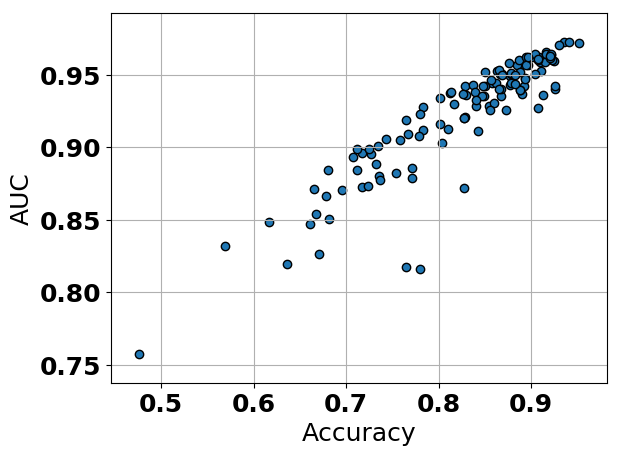

In [73]:
# find the model that generate the higest accuracy and plot
auc_combos = [i[0] for i in combos_performance]
acc_combos = [i[1] for i in combos_performance]

plt.scatter(auc_combos, acc_combos, edgecolors='black')
plt.xlabel('Accuracy')
plt.ylabel('AUC')
plt.grid()
plt.show()

Some of the models are relatively bad, but we see what appears to be a linear trend between AUC and accuracy.  Now we can find the model that generated the best accuracy.

In [126]:
# find the best model 
max_acc = 0; index=0;
for i, j in enumerate(acc_combos):
    if j > max_acc:
        max_acc = j
        index = i

# determine what features were included in this model
print 'Features included in best model:  ', combinations[index]
print 'Best accuaracy:  ', max_acc

Features included in best model:   (0, 1, 3, 4)
Best accuaracy:   0.972820512821


#### We find that the best model includes four features:  fixed_acidity, volatile_acidy, residual_sugar, and free_sulfur_dioxide.  

Finally, we can visualize the best decision tree.

In [112]:
# set of parameters to test
#wine_train, wine_test, class_train, class_test

param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 5, 10, 20, 50],
              "max_depth": [None, 2 , 4, 5, 10, 20],
              "min_samples_leaf": [1, 2, 3, 5, 10, 20, 50],
              "max_leaf_nodes": [None, 5, 10, 20 , 50],
              }
    
# gridsearch CV 10 fold, then generate a model w/ the best parameters
dtc = DTC()
clf = RandomizedSearchCV(dtc, param_grid, cv=10)
clf.fit(wine_train.iloc[:,list(combinations[index])], class_train)

dtc = DTC(criterion=clf.best_estimator_.criterion,
          min_samples_split = clf.best_estimator_.min_samples_split,
          max_depth = clf.best_estimator_.max_depth,
          min_samples_leaf = clf.best_estimator_.min_samples_leaf,
          max_leaf_nodes = clf.best_estimator_.max_leaf_nodes)

dtc.fit(wine_train.iloc[:,list(combinations[index])], class_train)


# display the tree!
output_dot = 'decision_tree.dot'
feature_names = ['fixed_acidity', 'volatile_acidy', 'residual_sugar', 'free_sulfur_dioxide']

with open(output_dot, 'w') as f:
    f = export_graphviz(dtc, out_file=f, feature_names=feature_names)
    
# paste the output into- 

In [123]:
%%bash
dot -Tpng decision_tree.dot -o decision_tree.png

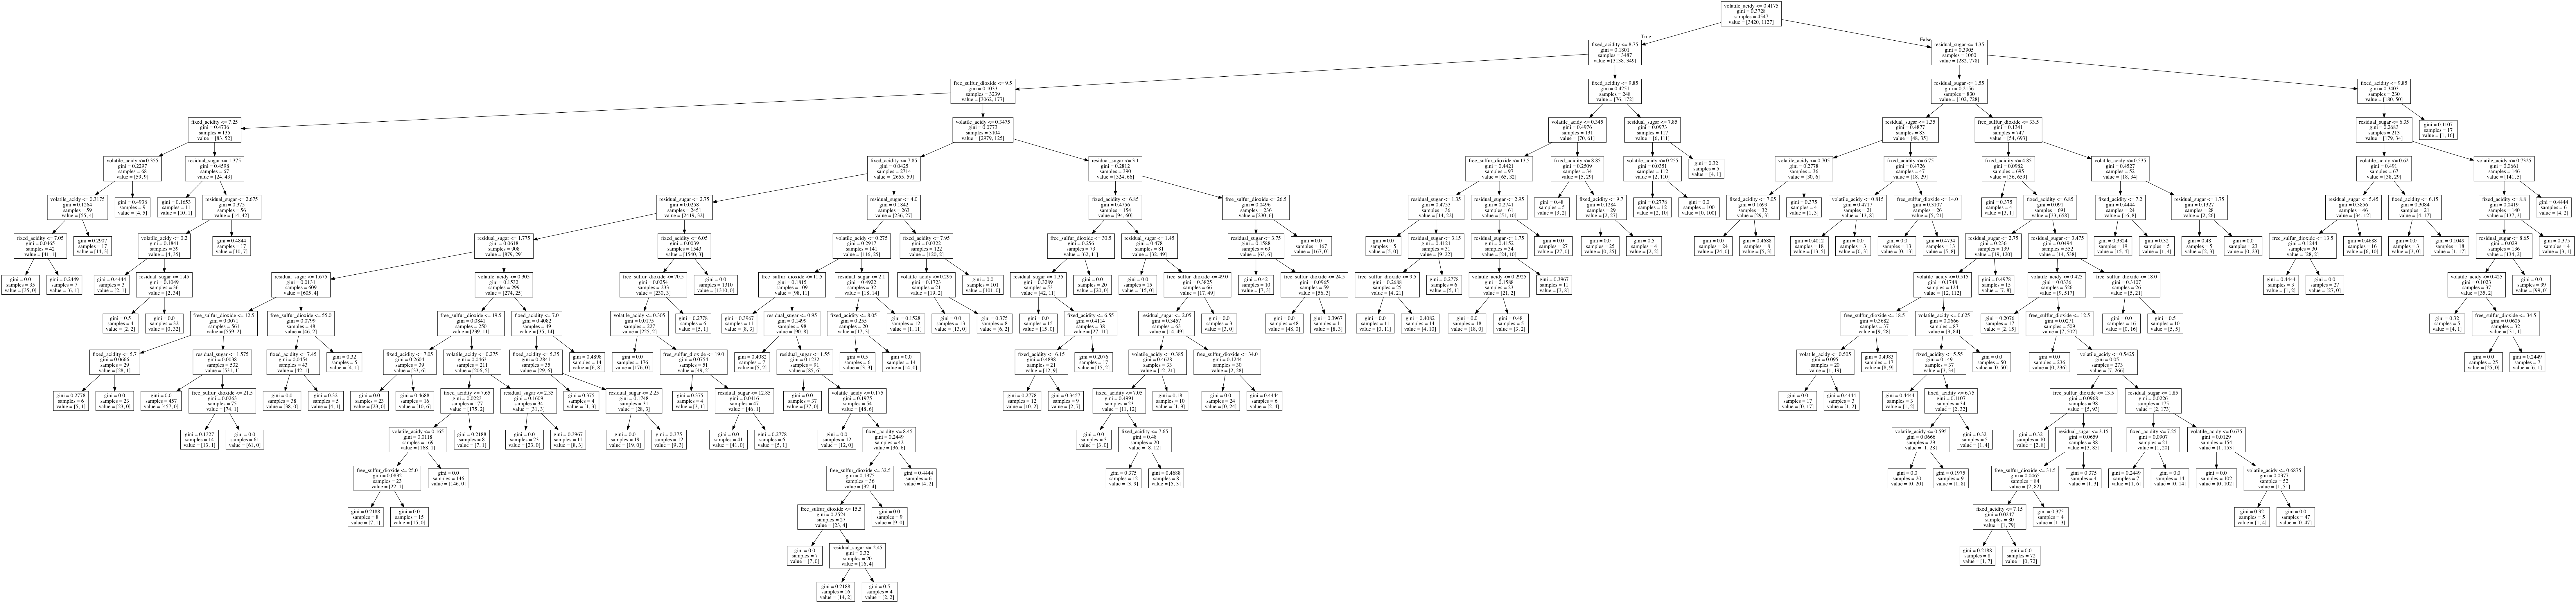

In [125]:
Image("decision_tree.png")

Kind of difficult to see because of the number of splits, but we can zoom in and focus on the first few to get an idea what the important features are.  The first split is on volatile_acidity, indicating that this feature divides the two classes the best.  The next two splits are on residual_sugar and fixed_acidity.  

In conclusion, we have generated a decision tree with four features that achieved 97.2% accuracy on the test data, and this was 1.1% better than a model that included all 7 features and that was not hyperparameter tuned.  This seems like a lot of effort for a 1.1% improvement, but nothing comes easy, I suppose!